In [103]:
# Importing the libraries
import os
import pandas as pd
import numpy as np
import datetime as dt
from math import sqrt


%matplotlib inline
import matplotlib.pyplot as plt
import pylab as pl
from matplotlib.colors import ListedColormap
import seaborn as sns
import itertools
from itertools import combinations

import warnings

from sklearn import preprocessing, linear_model, neighbors, datasets
from sklearn.linear_model import Lasso, Ridge, LinearRegression, SGDRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, mean_squared_error, f1_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, validation_curve, train_test_split, learning_curve, ShuffleSplit   
from xgboost.sklearn import XGBClassifier
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.base import clone 
from sklearn.svm import SVR
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor
from xgboost.sklearn import XGBRegressor
import lightgbm as lgb
import keras
from keras.models import Sequential
from keras.layers import Dense
np.random.seed(42)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [15]:
# Import datasets
train = pd.read_csv('C:/Users/banva/Desktop/Sports Project/PredictiveModelingAssessmentData.csv')
test = pd.read_csv('C:/Users/banva/Desktop/Sports Project/TestData.csv')
print(train.shape)
print(test.shape)
print(train.dtypes)

(5000, 3)
(5000, 3)
y     float64
x1    float64
x2    float64
dtype: object


# Data Understanding and Exploration

In [3]:
#Let's look at the basic stats for all the variables
train.describe()

,y,x1,x2
count,5000.000000,5000.000000,5000.000000
mean,1.048158,-0.003752,1.503146
std,1.992383,1.008551,1.077676
min,-9.847133,-3.503908,0.015279
25%,-0.193654,-0.674079,0.733216
50%,1.002366,-0.002352,1.252496
75%,2.201069,0.664764,2.017572
max,10.274068,3.274246,8.126406


In [6]:
#Check for Null values.
print(train.isnull().sum())
print(test.isnull().sum())
#There are no null values in the dataset

y     0
x1    0
x2    0
dtype: int64
ID    0
x1    0
x2    0
dtype: int64


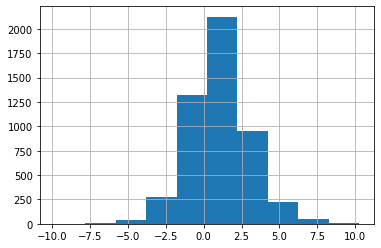

In [5]:
#Target Variable
train.y.hist()
#Pretty Normally distributed,and we don't need to do transformation for our target variable. 
#It is imperative to check, for example: Assumptions for Linear regression needs target variable to be normally distributed

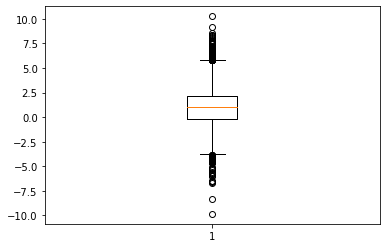

In [6]:
# Creating plot 
plt.boxplot(train.y) 
  
# show plot 
plt.show() 

#looking at Histogram and Boxplot,we see that the y values are raning from -10 to 10, 
#and most of the y values are cluttered between -5 to 7. 
#This will give a rough estimation on what a good rmse should look like. A rmse value:less than 1 would be good enough

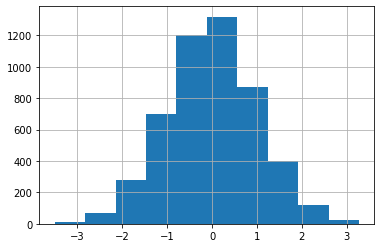

In [8]:
#Indepent Variable x1
train.x1.hist()
#this is normally distributed as well, so no need of transformation

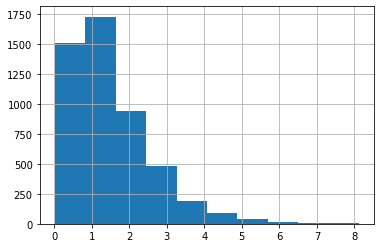

In [8]:
#Independent variable x2.
train.x2.hist()
#This is right skewed, so we might have to do log, or sq, cbrt transformations.

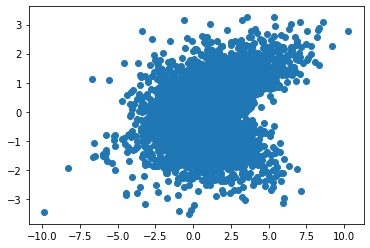

In [9]:
plt.scatter(train.y, train.x1)

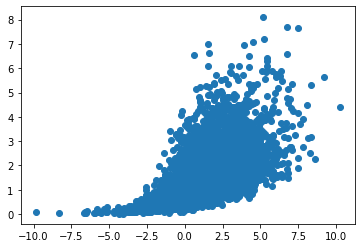

In [10]:
plt.scatter(train.y, train.x2)
#There is Heteroskedacity, which means the variance in y increases as x2 increases. we could transform x2 with log and see the variance. 

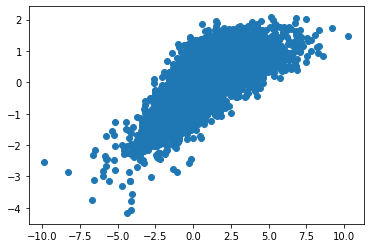

In [10]:
plt.scatter(train.y, np.log(train.x2))
#Now it is better, they are linearly dependent with each other.

# Feature Engineering

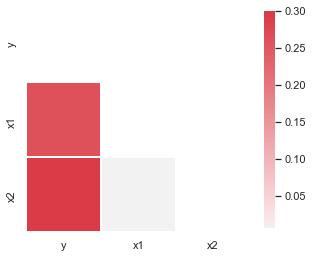

In [11]:
#Let's check for Multi Collinearity. If the two independent variables are multi collinear with each other then we can keep only one.
#Let's keep 0.9 as the max correlation cut-off.

#Plot Correlation Matrix
sns.set(style="white")

# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5,8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#Looks fine. No Multi collinearity

In [16]:
#Based on our understanding, we could try the following new variables to see if the model's performance improves.
#log(x1)
#log(x2)
#(x1)**2
#(x2)**2

# Modeling

In [16]:
# retrieving Attributes and train test split
y = train.loc[:,'y']
X = train.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train:test = 80:20
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [17]:
np.random.seed(42)
#Cross validation folds
inner_cv = KFold(n_splits=5, shuffle=True, random_state = 42) 
outer_cv = KFold(n_splits=10, shuffle=True, random_state = 42)

## Naive Rule

In [19]:
#train rmse with naive rule
naive_rmse = sqrt(mean_squared_error(y, np.repeat(y.mean(), 5000, axis=None)))
naive_rmse
#Our model's rmse has to be lesser than this value to say that a model is better than an average human prediction.

1.9921838091289135

## Linear regression

In [20]:
#Build the Linear regression model with training dataset
lr = LinearRegression().fit(X_train, y_train)

In [22]:
#let's look at the summary of our model object
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     1762.
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        22:46:38   Log-Likelihood:                -7190.5
No. Observations:                4000   AIC:                         1.439e+04
Df Residuals:                    3997   BIC:                         1.441e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7152      0.040    -17.989      0.0

In [24]:
lr_rmse_score = cross_val_score(LinearRegression(), X=X_train, y=y_train, cv=5, scoring ='neg_mean_squared_error')
print("\n Cross Validation rmse value of the training dataset: ", sqrt((-1)*lr_rmse_score.mean()))


 Cross Validation rmse value of the training dataset:  1.462220562074013


In [25]:
#Model evaluation on Test data
y_pred = lr.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.4393952295353796


In [26]:
#This model has a r-square value of 0.469, and train_rmse = 1.46, and test rmse = 1.439
#we could try feature engineered variables to see if the model performas better.


### Linear regression Model with feature engineered variables. I tried all possible combinations of these variables and found the best set of following variables for which I obtained the good scores of r2, train rmse and test rmse.

In [49]:
y = train.loc[:,'y']
X = train.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train:test = 80:20
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

#X_data has the following new variables
X_data = X_train
X_data['log_x1']= np.log(abs(X_data.x1))
X_data['log_x2']= np.log(abs(X_data.x2))
X_data['sq_x1']= (X_data.x1)**2
X_data.drop("x2", axis=1, inplace =True)
X_data

,x1,log_x1,log_x2,sq_x1
0,-0.866738,-0.143018,-0.906566,0.751235
1,1.812239,0.594563,0.310277,3.284209
2,0.526545,-0.641419,0.020211,0.277249
3,1.620758,0.482894,1.672229,2.626857
4,-1.225717,0.203526,-0.081710,1.502381
...,...,...,...,...
3995,-0.101566,-2.287048,0.530302,0.010316
3996,0.779787,-0.248735,0.167147,0.608067
3997,0.670703,-0.399429,0.527468,0.449842
3998,0.490512,-0.712306,1.462600,0.240602


In [50]:
X_train

,x1,log_x1,log_x2,sq_x1
0,-0.866738,-0.143018,-0.906566,0.751235
1,1.812239,0.594563,0.310277,3.284209
2,0.526545,-0.641419,0.020211,0.277249
3,1.620758,0.482894,1.672229,2.626857
4,-1.225717,0.203526,-0.081710,1.502381
...,...,...,...,...
3995,-0.101566,-2.287048,0.530302,0.010316
3996,0.779787,-0.248735,0.167147,0.608067
3997,0.670703,-0.399429,0.527468,0.449842
3998,0.490512,-0.712306,1.462600,0.240602


In [33]:
#Transform the test dataset as well.
X_test_data= X_test

X_test_data['log_x1']= np.log(abs(X_test_data.x1))
X_test_data['log_x2']= np.log(abs(X_test_data.x2))
X_test_data['sq_x1']= (X_test_data.x1)**2
X_test_data.drop("x2", axis=1, inplace =True)
X_test_data

,x1,log_x1,log_x2,sq_x1
0,1.441971,0.366011,-0.219958,2.079282
1,-0.558877,-0.581826,-1.198244,0.312343
2,-0.236218,-1.442999,1.188383,0.055799
3,-0.110294,-2.204607,-0.207546,0.012165
4,-0.013040,-4.339769,0.172297,0.000170
...,...,...,...,...
995,1.063089,0.061179,0.399560,1.130159
996,0.785551,-0.241370,0.071744,0.617090
997,-0.552301,-0.593663,0.344176,0.305036
998,-0.050793,-2.979995,1.216468,0.002580


In [34]:
lr = LinearRegression().fit(X_data, y_train)

In [35]:
X2 = sm.add_constant(X_data)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     2221.
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        23:16:26   Log-Likelihood:                -6113.7
No. Observations:                4000   AIC:                         1.224e+04
Df Residuals:                    3995   BIC:                         1.227e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7381      0.032     22.917      0.0

In [36]:
lr_rmse_score = cross_val_score(LinearRegression(), X=X_data, y=y_train, cv=5, scoring ='neg_mean_squared_error')
print("\n Cross Validation r-square value: ", sqrt((-1)*lr_rmse_score.mean()))


 Cross Validation r-square value:  1.118192050266969


In [37]:
#Model evaluation on Test data
y_pred = lr.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.09882404531328



### we see that r-squared value has greatly improved from 0.46 to 0.69. and rmse values are fairly imrproved as well. So far, the best scores are  train_rmse = 1.118 test_rmse= 1.09. Let's try to beat this score.

### Now, I am going to build several other algorithms with both basic variables and also feature engineered variables. Also,going to tune HyperParameters using Gridsearch cv to find the best parameters for each algorithms.


## Lasso Regression with basic variables

In [52]:
y = train.loc[:,'y']
X = train.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train:test = 80:20
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)


In [53]:
import sys
import warnings

if not sys.warnoptions:
 warnings.simplefilter("ignore") 


grid_lasso = GridSearchCV(estimator=Lasso(),
                  param_grid= [{'alpha':[0,0.25,0.5,0.75,1.0], 
                                'fit_intercept':[True,False], 
                                'normalize':[True,False], 
                                'max_iter':[1,5,10,15,20]}],  
                          scoring=  'neg_mean_squared_error', cv=inner_cv)
    
grid_lasso.fit(X_train,y_train) 

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n", grid_lasso.best_estimator_)
print("\n The best RMSE score across ALL searched params:\n",  sqrt((-1)*grid_lasso.best_score_))
print("\n The best parameters across ALL searched params:\n", grid_lasso.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 Lasso(alpha=0, copy_X=True, fit_intercept=True, max_iter=5, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

 The best RMSE score across ALL searched params:
 1.461967706970469

 The best parameters across ALL searched params:
 {'alpha': 0, 'fit_intercept': True, 'max_iter': 5, 'normalize': True}



In [54]:
grid_lasso_r_squared = cross_val_score(grid_lasso.best_estimator_, X=X_train, y=y_train, cv=outer_cv, scoring ='r2')
print("\n Cross Validation r-square value: ",grid_lasso_r_squared.mean())


 Cross Validation r-square value:  0.4653894050630508


In [55]:
#Model evaluation on Test data
y_pred = grid_lasso.best_estimator_.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.4393952295353796


## Lasso Regression with feature engineering variables

In [72]:
y = train.loc[:,'y']
X = train.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train:test = 80:20
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

#X_data has the following new variables
X_data = X_train
X_data['log_x1']= np.log(abs(X_data.x1))
X_data['log_x2']= np.log(abs(X_data.x2))
X_data['sq_x1']= (X_data.x1)**2
X_data.drop("x2", axis=1, inplace =True)


#Transform the test dataset as well.
X_test_data= X_test

X_test_data['log_x1']= np.log(abs(X_test_data.x1))
X_test_data['log_x2']= np.log(abs(X_test_data.x2))
X_test_data['sq_x1']= (X_test_data.x1)**2
X_test_data.drop("x2", axis=1, inplace =True)


In [60]:
import sys
import warnings

if not sys.warnoptions:
 warnings.simplefilter("ignore") 


grid_lasso_feature = GridSearchCV(estimator=Lasso(),
                  param_grid= [{'alpha':[0,0.25,0.5,0.75,1.0], 
                                'fit_intercept':[True,False], 
                                'normalize':[True,False], 
                                'max_iter':[1,5,10,15,20]}],  
                          scoring=  'neg_mean_squared_error', cv=inner_cv)
    
grid_lasso_feature.fit(X_data,y_train)

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n", grid_lasso_feature.best_estimator_)
print("\n The best RMSE score across ALL searched params:\n",  sqrt((-1)*grid_lasso_feature.best_score_))
print("\n The best parameters across ALL searched params:\n", grid_lasso_feature.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 Lasso(alpha=0, copy_X=True, fit_intercept=True, max_iter=20, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

 The best RMSE score across ALL searched params:
 1.1181747387677419

 The best parameters across ALL searched params:
 {'alpha': 0, 'fit_intercept': True, 'max_iter': 20, 'normalize': True}



In [79]:
grid_lasso_feature_r_squared = cross_val_score(grid_lasso_feature.best_estimator_, X=X_data, y=y_train, cv=outer_cv, scoring ='r2')
print("\n Cross Validation r-square value: ",grid_lasso_feature_r_squared.mean())


 Cross Validation r-square value:  0.687727169878163


In [80]:
#Model evaluation on Test data
y_pred = grid_lasso_feature.best_estimator_.predict(X_test_data)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.0988240456426714


In [ ]:
#Comments: Feature engineered variables have driven siginificant improvement in the scores. 
#And the alpha parameter in the Lasso regression suggests that the model best performs when there is no regularization.
#This is now very similar to the Linear regression model.
#Also, the model performed better on test data set than on train dataset, whicch means there is less variance, and good bias.

## Ridge regression with basic variables

In [73]:
y = train.loc[:,'y']
X = train.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train:test = 80:20
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)


In [74]:
grid_ridge = GridSearchCV(estimator=Ridge(),
                  param_grid= [{'alpha':[0,0.25,0.5,0.75,1.0], 
                                'fit_intercept':[True,False], 
                                'normalize':[True,False], 
                                'max_iter':[1,5,10,15,20]}],  
                          scoring=  'neg_mean_squared_error', cv=inner_cv)

    
grid_ridge.fit(X_train,y_train)

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n", grid_ridge.best_estimator_)
print("\n The best score across ALL searched params:\n",  sqrt((-1)*grid_ridge.best_score_))
print("\n The best parameters across ALL searched params:\n", grid_ridge.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1, normalize=False,
      random_state=None, solver='auto', tol=0.001)

 The best score across ALL searched params:
 1.4619674162348684

 The best parameters across ALL searched params:
 {'alpha': 1.0, 'fit_intercept': True, 'max_iter': 1, 'normalize': False}



In [75]:
grid_ridge_r_squared = cross_val_score(grid_ridge.best_estimator_, X=X_train, y=y_train, cv=outer_cv, scoring ='r2')
print("\n Cross Validation r-square value: ",grid_ridge_r_squared.mean())


 Cross Validation r-square value:  0.4653904597238078


In [76]:
#Model evaluation on Test data
y_pred = grid_ridge.best_estimator_.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.439375758746714


## Ridge Regression with feature engineering variables

In [77]:
y = train.loc[:,'y']
X = train.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train:test = 80:20
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

#X_data has the following new variables
X_data = X_train
X_data['log_x1']= np.log(abs(X_data.x1))
X_data['log_x2']= np.log(abs(X_data.x2))
X_data['sq_x1']= (X_data.x1)**2
X_data.drop("x2", axis=1, inplace =True)


#Transform the test dataset as well.
X_test_data= X_test

X_test_data['log_x1']= np.log(abs(X_test_data.x1))
X_test_data['log_x2']= np.log(abs(X_test_data.x2))
X_test_data['sq_x1']= (X_test_data.x1)**2
X_test_data.drop("x2", axis=1, inplace =True)


In [78]:
import sys
import warnings

if not sys.warnoptions:
 warnings.simplefilter("ignore") 


grid_ridge_feature = GridSearchCV(estimator=Ridge(),
                  param_grid= [{'alpha':[0,0.25,0.5,0.75,1.0], 
                                'fit_intercept':[True,False], 
                                'normalize':[True,False], 
                                'max_iter':[1,5,10,15,20]}],  
                          scoring=  'neg_mean_squared_error', cv=inner_cv)
    
grid_ridge_feature.fit(X_data,y_train)

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n", grid_ridge_feature.best_estimator_)
print("\n The best RMSE score across ALL searched params:\n",  sqrt((-1)*grid_ridge_feature.best_score_))
print("\n The best parameters across ALL searched params:\n", grid_ridge_feature.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 Ridge(alpha=0.25, copy_X=True, fit_intercept=True, max_iter=1, normalize=False,
      random_state=None, solver='auto', tol=0.001)

 The best RMSE score across ALL searched params:
 1.1181747166372284

 The best parameters across ALL searched params:
 {'alpha': 0.25, 'fit_intercept': True, 'max_iter': 1, 'normalize': False}



In [81]:
grid_ridge_feature_r_squared = cross_val_score(grid_ridge_feature.best_estimator_, X=X_data, y=y_train, cv=outer_cv, scoring ='r2')
print("\n Cross Validation r-square value: ",grid_lasso_feature_r_squared.mean())


 Cross Validation r-square value:  0.687727169878163


In [82]:
#Model evaluation on Test data
y_pred = grid_ridge_feature.best_estimator_.predict(X_test_data)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.0988224408261433


In [83]:
#Ridge performed very similar to Lasso.

## Regression Tree with basic variables

In [88]:
y = train.loc[:,'y']
X = train.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train:test = 80:20
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)


In [89]:
parameters_grid = [{'max_depth' :[2,5,10] , 'min_samples_split' : [2, 5, 10] , 'max_leaf_nodes' : [2,5,10]}]

grid_rt = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid= parameters_grid, scoring=  'neg_mean_squared_error', cv=inner_cv)

grid_rt.fit(X_train,y_train)

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n", grid_rt.best_estimator_)
print("\n The best score across ALL searched params:\n",  sqrt((-1)*grid_rt.best_score_))
print("\n The best parameters across ALL searched params:\n", grid_rt.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=10,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

 The best score across ALL searched params:
 1.244261122289668

 The best parameters across ALL searched params:
 {'max_depth': 5, 'max_leaf_nodes': 10, 'min_samples_split': 2}



In [90]:
grid_rt_r_squared = cross_val_score(grid_rt.best_estimator_, X=X_train, y=y_train, cv=outer_cv, scoring ='r2')
print("\n Cross Validation r-square value: ",grid_rt_r_squared.mean())


 Cross Validation r-square value:  0.6185108561397626


In [91]:
#Model evaluation on Test data
y_pred = grid_rt.best_estimator_.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.2044982457054345


## Regression Tree with Feature Engineering Variables

In [ ]:
y = train.loc[:,'y']
X = train.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train:test = 80:20
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

#X_data has the following new variables
X_data = X_train
X_data['log_x1']= np.log(abs(X_data.x1))
X_data['log_x2']= np.log(abs(X_data.x2))
X_data['sq_x1']= (X_data.x1)**2
X_data.drop("x2", axis=1, inplace =True)


#Transform the test dataset as well.
X_test_data= X_test

X_test_data['log_x1']= np.log(abs(X_test_data.x1))
X_test_data['log_x2']= np.log(abs(X_test_data.x2))
X_test_data['sq_x1']= (X_test_data.x1)**2
X_test_data.drop("x2", axis=1, inplace =True)


In [92]:
import sys
import warnings

if not sys.warnoptions:
 warnings.simplefilter("ignore") 


grid_rt_feature = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid= parameters_grid, scoring=  'neg_mean_squared_error', cv=inner_cv)

grid_rt_feature.fit(X_data,y_train)

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n", grid_rt_feature.best_estimator_)
print("\n The best rmse score across ALL searched params:\n",  sqrt((-1)*grid_rt_feature.best_score_))
print("\n The best parameters across ALL searched params:\n", grid_rt_feature.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=10,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

 The best rmse score across ALL searched params:
 1.2429628608913146

 The best parameters across ALL searched params:
 {'max_depth': 5, 'max_leaf_nodes': 10, 'min_samples_split': 2}



In [93]:
grid_rt_feature_r_squared = cross_val_score(grid_rt_feature.best_estimator_, X=X_data, y=y_train, cv=outer_cv, scoring ='r2')
print("\n Cross Validation r-square value: ",grid_rt_feature_r_squared.mean())


 Cross Validation r-square value:  0.6208556593737252


In [94]:
#Model evaluation on Test data
y_pred = grid_rt_feature.best_estimator_.predict(X_test_data)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.2051499014451883


In [95]:
#Comments:
#This model has poor R-square and rmse as compared to Linear models.

## Random Forrest Regressor

In [20]:
y = train.loc[:,'y']
X = train.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train:test = 80:20
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)


In [25]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 150, stop = 250, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5,10, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,10,50]
# Create the random grid
parameters_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

grid_rfr.fit(X_train,y_train)

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n", grid_rfr.best_estimator_)
print("\n The best score across ALL searched params:\n",  sqrt((-1)*grid_rfr.best_score_))
print("\n The best parameters across ALL searched params:\n", grid_rfr.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

 The best score across ALL searched params:
 1.0366147249968745

 The best parameters across ALL searched params:
 {'max_depth': 7, 'max_features': 'auto', 'n_estimators': 150}



In [26]:
grid_rfr_r_squared = cross_val_score(grid_rfr.best_estimator_, X=X_train, y=y_train, cv=outer_cv, scoring ='r2')
print("\n Cross Validation r-square value: ",grid_rfr_r_squared.mean())


 Cross Validation r-square value:  0.7313594503662596


In [27]:
#Model evaluation on Test data
y_pred = grid_rfr.best_estimator_.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.0228715623625564


## Random forest with Feature Engineering Variables

In [28]:
y = train.loc[:,'y']
X = train.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train:test = 80:20
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

#X_data has the following new variables
X_data = X_train
X_data['log_x1']= np.log(abs(X_data.x1))
X_data['log_x2']= np.log(abs(X_data.x2))
X_data['sq_x1']= (X_data.x1)**2
X_data.drop("x2", axis=1, inplace =True)


#Transform the test dataset as well.
X_test_data= X_test

X_test_data['log_x1']= np.log(abs(X_test_data.x1))
X_test_data['log_x2']= np.log(abs(X_test_data.x2))
X_test_data['sq_x1']= (X_test_data.x1)**2
X_test_data.drop("x2", axis=1, inplace =True)


In [29]:
grid_rfr_feature = GridSearchCV(estimator=RandomForestRegressor(),
                  param_grid= [{ 
    'n_estimators': [150,200,300],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [4,7,10]}], scoring=  'neg_mean_squared_error', cv=inner_cv)

    
grid_rfr_feature.fit(X_data,y_train)

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n", grid_rfr_feature.best_estimator_)
print("\n The best score across ALL searched params:\n",  sqrt((-1)*grid_rfr_feature.best_score_))
print("\n The best parameters across ALL searched params:\n", grid_rfr_feature.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

 The best score across ALL searched params:
 1.036638033740569

 The best parameters across ALL searched params:
 {'max_depth': 7, 'max_features': 'auto', 'n_estimators': 300}



In [30]:
grid_rfr_feature_r_squared = cross_val_score(grid_rfr_feature.best_estimator_, X=X_data, y=y_train, cv=5, scoring ='r2')
print("\n Cross Validation r-square value: ",grid_rfr_feature_r_squared.mean())


 Cross Validation r-square value:  0.7303993741669237


In [31]:
#Model evaluation on Test data
y_pred = grid_rfr_feature.best_estimator_.predict(X_test_data)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.0220494559250575


In [32]:
#Comments
#R-square for Random forest odel with Feature engineering variables is slightly better, 
#By far, this is the best model we have now

## SVM with basic Variables

In [40]:
y = train.loc[:,'y']
X = train.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train:test = 80:20
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)


In [41]:
parameters_grid = [{'kernel': ('linear', 'rbf','poly'), 'C':[1.5, 10],'gamma': [ 0.1, 0.01, 0.001, 0.0001]}]
        
grid_svr = GridSearchCV(estimator=SVR(),
                  param_grid= parameters_grid, scoring=  'neg_mean_squared_error', cv=inner_cv)


grid_svr.fit(X_train,y_train)

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n", grid_svr.best_estimator_)
print("\n The best score across ALL searched params:\n",  sqrt((-1)*grid_svr.best_score_))
print("\n The best parameters across ALL searched params:\n", grid_svr.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

 The best score across ALL searched params:
 1.046435231879711

 The best parameters across ALL searched params:
 {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}



In [42]:
grid_svr_r_squared = cross_val_score(grid_svr.best_estimator_, X=X_train, y=y_train, cv=outer_cv, scoring ='r2')
print("\n Cross Validation r-square value: ",grid_svr_r_squared.mean())


 Cross Validation r-square value:  0.7256078008590374


In [43]:
#Model evaluation on Test data
y_pred = grid_svr.best_estimator_.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.0410821364379068


## SVM with feature engineering Variables

In [44]:
y = train.loc[:,'y']
X = train.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train:test = 80:20
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

#X_data has the following new variables
X_data = X_train
X_data['log_x1']= np.log(abs(X_data.x1))
X_data['log_x2']= np.log(abs(X_data.x2))
X_data['sq_x1']= (X_data.x1)**2
X_data.drop("x2", axis=1, inplace =True)


#Transform the test dataset as well.
X_test_data= X_test

X_test_data['log_x1']= np.log(abs(X_test_data.x1))
X_test_data['log_x2']= np.log(abs(X_test_data.x2))
X_test_data['sq_x1']= (X_test_data.x1)**2
X_test_data.drop("x2", axis=1, inplace =True)


In [45]:
parameters_grid = {'kernel': ('linear', 'rbf','poly'), 'C':[1.5, 10],'gamma': [ 0.1, 0.01, 0.001, 0.0001]}
        
grid_svr_feature = GridSearchCV(estimator=SVR(),
                  param_grid= parameters_grid, scoring=  'neg_mean_squared_error', cv=inner_cv)


grid_svr_feature.fit(X_data,y_train)

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n", grid_svr_feature.best_estimator_)
print("\n The best score across ALL searched params:\n",  sqrt((-1)*grid_svr_feature.best_score_))
print("\n The best parameters across ALL searched params:\n", grid_svr_feature.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

 The best score across ALL searched params:
 1.0132280371136186

 The best parameters across ALL searched params:
 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}



In [46]:
grid_svr_feature_r_squared = cross_val_score(grid_svr_feature.best_estimator_, X=X_data, y=y_train, cv=outer_cv, scoring ='r2')
print("\n Cross Validation r-square value: ",grid_svr_feature_r_squared.mean())


 Cross Validation r-square value:  0.7432692293517806


In [47]:
#Model evaluation on Test data
y_pred = grid_svr_feature.best_estimator_.predict(X_test_data)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.0018851680159457


In [ ]:
#comments: R-square value  and Rmse values for SVM with feature engineering variables are way better than SVM with basic variables. 
#By far, this is the best model.

## Stochastic Gradient Regressor with basic Variables

In [48]:
y = train.loc[:,'y']
X = train.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train:test = 80:20
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)


In [56]:
parameters_grid = [{'loss': ['squared_loss', 'huber'],
    'penalty': ['l2', 'l1'],
    'learning_rate': ['constant', 'optimal']
}]
grid_sgr = GridSearchCV(estimator=SGDRegressor(),
                  param_grid= parameters_grid, scoring=  'neg_mean_squared_error', cv=inner_cv)


grid_sgr.fit(X_train,y_train)

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n", grid_sgr.best_estimator_)
print("\n The best score across ALL searched params:\n",  sqrt((-1)*grid_sgr.best_score_))
print("\n The best parameters across ALL searched params:\n", grid_sgr.best_params_)
print("\n ========================================================")



 Results from Grid Search 

 The best estimator across ALL searched params:
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='huber', max_iter=1000,
             n_iter_no_change=5, penalty='l1', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

 The best score across ALL searched params:
 1.4604047273124103

 The best parameters across ALL searched params:
 {'learning_rate': 'constant', 'loss': 'huber', 'penalty': 'l1'}



In [57]:
grid_sgr_r_squared = cross_val_score(grid_sgr.best_estimator_, X=X_train, y=y_train, cv=outer_cv, scoring ='r2')
print("\n Cross Validation r-square value: ",grid_sgr_r_squared.mean())


 Cross Validation r-square value:  0.46369737432305647


In [58]:
#Model evaluation on Test data
y_pred = grid_sgr.best_estimator_.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.4391343560564107


## Stochastic Gradient Regressor with feature engineering Variables

In [59]:
y = train.loc[:,'y']
X = train.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train:test = 80:20
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

#X_data has the following new variables
X_data = X_train
X_data['log_x1']= np.log(abs(X_data.x1))
X_data['log_x2']= np.log(abs(X_data.x2))
X_data['sq_x1']= (X_data.x1)**2
X_data.drop("x2", axis=1, inplace =True)


#Transform the test dataset as well.
X_test_data= X_test

X_test_data['log_x1']= np.log(abs(X_test_data.x1))
X_test_data['log_x2']= np.log(abs(X_test_data.x2))
X_test_data['sq_x1']= (X_test_data.x1)**2
X_test_data.drop("x2", axis=1, inplace =True)


In [60]:
parameters_grid = {
    'alpha': 10.0 ** -np.arange(1, 5),
    'loss': ['squared_loss', 'huber'],
    'penalty': ['l2', 'l1'],
    'learning_rate': ['constant', 'optimal' ],
}
grid_sgr_feature = GridSearchCV(estimator=SGDRegressor(),
                  param_grid= parameters_grid, scoring=  'neg_mean_squared_error', cv=inner_cv)


grid_sgr_feature.fit(X_data,y_train)

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n", grid_sgr_feature.best_estimator_)
print("\n The best score across ALL searched params:\n",  sqrt((-1)*grid_sgr_feature.best_score_))
print("\n The best parameters across ALL searched params:\n", grid_sgr_feature.best_params_)
print("\n ========================================================")



 Results from Grid Search 

 The best estimator across ALL searched params:
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='huber', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

 The best score across ALL searched params:
 1.1190832008957028

 The best parameters across ALL searched params:
 {'alpha': 0.0001, 'learning_rate': 'constant', 'loss': 'huber', 'penalty': 'l2'}



In [61]:
grid_sgr_feature_r_squared = cross_val_score(grid_sgr_feature.best_estimator_, X=X_data, y=y_train, cv=outer_cv, scoring ='r2')
print("\n Cross Validation r-square value: ",grid_sgr_feature_r_squared.mean())


 Cross Validation r-square value:  0.6854155795767147


In [62]:
#Model evaluation on Test data
y_pred = grid_sgr_feature.best_estimator_.predict(X_test_data)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.096736182042758


In [ ]:
#Comments
#This model isn't better compared to SVM. We can just ignore this model

## Gradient Boosting regressor with basic variables

In [63]:
y = train.loc[:,'y']
X = train.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train:test = 80:20
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)


In [64]:
parameters_grid = {'learning_rate': [0.005,0.01],
                  'subsample'    : [0.5, 0.2,0.1],
                  'n_estimators' : [500,1000, 5000],
                  'max_depth'    : [2,4,6]
                 }

grid_gb = GridSearchCV(estimator= GradientBoostingRegressor(), param_grid = parameters_grid, cv = 2, n_jobs=-1, scoring = 'neg_mean_squared_error')
grid_gb.fit(X_train, y_train)

 # Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n", grid_gb.best_estimator_)
print("\n The best score across ALL searched params:\n", sqrt((-1)*grid_gb.best_score_))
print("\n The best parameters across ALL searched params:\n", grid_gb.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.1, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

 The best score across ALL searched params:
 1.0247175182542203

 The best parameters across ALL searched params:
 {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.1}



In [65]:
grid_gb_r_squared = cross_val_score(grid_gb.best_estimator_, X=X_train, y=y_train, cv=outer_cv, scoring ='r2')
print("\n Cross Validation r-square value: ",grid_gb_r_squared.mean())


 Cross Validation r-square value:  0.7402307673994538


In [66]:
#Model evaluation on Test data
y_pred = grid_svr.best_estimator_.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.0410821364379068


## Gradient Boosting Regressor with Feature Engineering Variables

In [67]:
y = train.loc[:,'y']
X = train.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train:test = 80:20
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

#X_data has the following new variables
X_data = X_train
X_data['log_x1']= np.log(abs(X_data.x1))
X_data['log_x2']= np.log(abs(X_data.x2))
X_data['sq_x1']= (X_data.x1)**2
X_data.drop("x2", axis=1, inplace =True)


#Transform the test dataset as well.
X_test_data= X_test

X_test_data['log_x1']= np.log(abs(X_test_data.x1))
X_test_data['log_x2']= np.log(abs(X_test_data.x2))
X_test_data['sq_x1']= (X_test_data.x1)**2
X_test_data.drop("x2", axis=1, inplace =True)


In [68]:
parameters_grid = {'learning_rate': [0.005,0.01],
                  'subsample'    : [0.5, 0.2,0.1],
                  'n_estimators' : [500,1000, 5000],
                  'max_depth'    : [2,4,6]
                 }

grid_gb_feature = GridSearchCV(estimator= GradientBoostingRegressor(), param_grid = parameters_grid, cv = 2, n_jobs=-1, scoring = 'neg_mean_squared_error')
grid_gb_feature.fit(X_data, y_train)

 # Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n", grid_gb_feature.best_estimator_)
print("\n The best score across ALL searched params:\n", sqrt((-1)*grid_gb_feature.best_score_))
print("\n The best parameters across ALL searched params:\n", grid_gb_feature.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.005, loss='ls',
                          max_depth=4, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.1, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

 The best score across ALL searched params:
 1.0218065883559202

 The best parameters across ALL searched params:
 {'learning_rate': 0.005, 'max_depth': 4, 'n_estimators': 1000, 'subsample': 0.1}



In [69]:
grid_gb_feature_r_squared = cross_val_score(grid_gb_feature.best_estimator_, X=X_data, y=y_train, cv=outer_cv, scoring ='r2')
print("\n Cross Validation r-square value: ",grid_gb_feature_r_squared.mean())


 Cross Validation r-square value:  0.7408966009888076


In [70]:
#Model evaluation on Test data
y_pred = grid_gb_feature.best_estimator_.predict(X_test_data)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.010773035459162


In [ ]:
#Comments:
#Gradientboosting regressor' r-squared value is very slightly better when basic variables are used, but rmse is slighly more better 
#when feature engineering variables are used

#Overall, this model performed fairly close to SVM. we could probably ensemble this model with SVM to get better performance.

## XGBoost regressor with basic variables

In [71]:
y = train.loc[:,'y']
X = train.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train:test = 80:20
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)


In [72]:
parameters_grid = {'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'subsample': [0.7 ,2,5],
              'n_estimators': [50,100,500]}

grid_xgb = GridSearchCV(estimator= XGBRegressor(), param_grid = parameters_grid, cv = 2, n_jobs=-1, scoring = 'neg_mean_squared_error')
grid_xgb.fit(X_train, y_train)

 # Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n", grid_xgb.best_estimator_)
print("\n The best score across ALL searched params:\n", sqrt((-1)*grid_xgb.best_score_))
print("\n The best parameters across ALL searched params:\n", grid_xgb.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7, tree_method=None,
             validate_parameters=False, verbosity=None)

 The best score across ALL searched params:
 1.0388908461999202

 The best parameters across ALL searched params:
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}



In [73]:
grid_xgb_r_squared = cross_val_score(grid_xgb.best_estimator_, X=X_train, y=y_train, cv=outer_cv, scoring ='r2')
print("\n Cross Validation r-square value: ",grid_xgb_r_squared.mean())


 Cross Validation r-square value:  0.7346149484097525


In [74]:
#Model evaluation on Test data
y_pred = grid_xgb.best_estimator_.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.0203494551498262


## XGBoost Regressor with Feature Engineering Variables

In [75]:
y = train.loc[:,'y']
X = train.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train:test = 80:20
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

#X_data has the following new variables
X_data = X_train
X_data['log_x1']= np.log(abs(X_data.x1))
X_data['log_x2']= np.log(abs(X_data.x2))
X_data['sq_x1']= (X_data.x1)**2
X_data.drop("x2", axis=1, inplace =True)


#Transform the test dataset as well.
X_test_data= X_test

X_test_data['log_x1']= np.log(abs(X_test_data.x1))
X_test_data['log_x2']= np.log(abs(X_test_data.x2))
X_test_data['sq_x1']= (X_test_data.x1)**2
X_test_data.drop("x2", axis=1, inplace =True)


In [76]:
parameters_grid = {'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'subsample': [0.7 ,2,5],
              'n_estimators': [50,100,500]}

grid_xgb_feature = GridSearchCV(estimator= XGBRegressor(), param_grid = parameters_grid, cv = 2, n_jobs=-1, scoring = 'neg_mean_squared_error')
grid_xgb_feature.fit(X_data, y_train)

 # Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n", grid_xgb_feature.best_estimator_)
print("\n The best score across ALL searched params:\n", sqrt((-1)*grid_xgb_feature.best_score_))
print("\n The best parameters across ALL searched params:\n", grid_xgb_feature.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7, tree_method=None,
             validate_parameters=False, verbosity=None)

 The best score across ALL searched params:
 1.037641894871453

 The best parameters across ALL searched params:
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}



In [77]:
grid_xgb_feature_r_squared = cross_val_score(grid_xgb_feature.best_estimator_, X=X_data, y=y_train, cv=outer_cv, scoring ='r2')
print("\n Cross Validation r-square value: ",grid_xgb_feature_r_squared.mean())


 Cross Validation r-square value:  0.735441664462116


In [78]:
#Model evaluation on Test data
y_pred = grid_xgb_feature.best_estimator_.predict(X_test_data)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.0184472321851092


In [ ]:
#Comments:
#XGBoost performed better with feature engineering variables,but SVM is stil better than this model by a small margin

## Adaboost Regressor

In [89]:
y = train.loc[:,'y']
X = train.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train:test = 80:20
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)


In [90]:
parameters_grid = {
 'n_estimators': [50, 100],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'loss' : ['linear', 'square', 'exponential']
 }
grid_ab = GridSearchCV(estimator= AdaBoostRegressor(), param_grid = parameters_grid, cv = 2, n_jobs=-1, scoring = 'neg_mean_squared_error')
grid_ab.fit(X_train, y_train)

 # Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n", grid_ab.best_estimator_)
print("\n The best score across ALL searched params:\n", sqrt((-1)*grid_ab.best_score_))
print("\n The best parameters across ALL searched params:\n", grid_ab.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 AdaBoostRegressor(base_estimator=None, learning_rate=0.3, loss='exponential',
                  n_estimators=100, random_state=None)

 The best score across ALL searched params:
 1.1006558307115666

 The best parameters across ALL searched params:
 {'learning_rate': 0.3, 'loss': 'exponential', 'n_estimators': 100}



In [92]:
grid_ab_r_squared = cross_val_score(grid_ab.best_estimator_, X=X_train, y=y_train, cv=outer_cv, scoring ='r2')
print("\n Cross Validation r-square value: ",grid_ab_r_squared.mean())


 Cross Validation r-square value:  0.7054318998850319


In [93]:
#Model evaluation on Test data
y_pred = grid_ab.best_estimator_.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.0780875107020624


## Adaboost Regressor with feature Engineering Variables

In [94]:
y = train.loc[:,'y']
X = train.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train:test = 80:20
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

#X_data has the following new variables
X_data = X_train
X_data['log_x1']= np.log(abs(X_data.x1))
X_data['log_x2']= np.log(abs(X_data.x2))
X_data['sq_x1']= (X_data.x1)**2
X_data.drop("x2", axis=1, inplace =True)


#Transform the test dataset as well.
X_test_data= X_test

X_test_data['log_x1']= np.log(abs(X_test_data.x1))
X_test_data['log_x2']= np.log(abs(X_test_data.x2))
X_test_data['sq_x1']= (X_test_data.x1)**2
X_test_data.drop("x2", axis=1, inplace =True)


In [95]:
parameters_grid = {
 'n_estimators': [50, 100],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'loss' : ['linear', 'square', 'exponential']
 }
grid_ab_feature = GridSearchCV(estimator= AdaBoostRegressor(), param_grid = parameters_grid, cv = 2, n_jobs=-1, scoring = 'neg_mean_squared_error')
grid_ab_feature.fit(X_data, y_train)

 # Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n", grid_ab_feature.best_estimator_)
print("\n The best score across ALL searched params:\n", sqrt((-1)*grid_ab_feature.best_score_))
print("\n The best parameters across ALL searched params:\n", grid_ab_feature.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 AdaBoostRegressor(base_estimator=None, learning_rate=1, loss='square',
                  n_estimators=100, random_state=None)

 The best score across ALL searched params:
 1.077010520841031

 The best parameters across ALL searched params:
 {'learning_rate': 1, 'loss': 'square', 'n_estimators': 100}



In [96]:
grid_ab_feature_r_squared = cross_val_score(grid_ab_feature.best_estimator_, X=X_data, y=y_train, cv=outer_cv, scoring ='r2')
print("\n Cross Validation r-square value: ",grid_ab_feature_r_squared.mean())


 Cross Validation r-square value:  0.7172869967714866


In [97]:
#Model evaluation on Test data
y_pred = grid_ab_feature.best_estimator_.predict(X_test_data)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.0500946672021227


In [ ]:
#Comments:
#Again, this is not close to SVM, so we can ignore this.

## Catboost Regressor

In [104]:
y = train.loc[:,'y']
X = train.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train:test = 80:20
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [106]:
parameters_grid = {'depth' : [6,8,10],
                  'learning_rate' : [0.01, 0.05, 0.1],
                  'iterations'    : [30, 50, 100]
                 }
grid_cb = GridSearchCV(estimator= CatBoostRegressor(), param_grid = parameters_grid, cv = 2, n_jobs=-1, scoring = 'neg_mean_squared_error')
grid_cb.fit(X_train, y_train)

 # Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n", grid_cb.best_estimator_)
print("\n The best score across ALL searched params:\n", sqrt((-1)*grid_cb.best_score_))
print("\n The best parameters across ALL searched params:\n", grid_cb.best_params_)
print("\n ========================================================")   

0:	learn: 1.8763687	total: 56.5ms	remaining: 5.59s
1:	learn: 1.7649060	total: 60.3ms	remaining: 2.95s
2:	learn: 1.6697736	total: 63.6ms	remaining: 2.06s
3:	learn: 1.5855734	total: 67.1ms	remaining: 1.61s
4:	learn: 1.5131130	total: 70.4ms	remaining: 1.34s
5:	learn: 1.4492463	total: 73.8ms	remaining: 1.16s
6:	learn: 1.3945375	total: 77.1ms	remaining: 1.02s
7:	learn: 1.3436112	total: 80.4ms	remaining: 925ms
8:	learn: 1.3004519	total: 83.7ms	remaining: 846ms
9:	learn: 1.2608308	total: 86.9ms	remaining: 782ms
10:	learn: 1.2249937	total: 90.1ms	remaining: 729ms
11:	learn: 1.1958836	total: 93.4ms	remaining: 685ms
12:	learn: 1.1719878	total: 96.9ms	remaining: 648ms
13:	learn: 1.1507621	total: 100ms	remaining: 616ms
14:	learn: 1.1314784	total: 104ms	remaining: 587ms
15:	learn: 1.1145235	total: 107ms	remaining: 562ms
16:	learn: 1.0997671	total: 110ms	remaining: 539ms
17:	learn: 1.0876683	total: 114ms	remaining: 519ms
18:	learn: 1.0763648	total: 117ms	remaining: 501ms
19:	learn: 1.0678829	total: 

In [107]:
grid_cb_r_squared = cross_val_score(grid_cb.best_estimator_, X=X_train, y=y_train, cv=outer_cv, scoring ='r2')
print("\n Cross Validation r-square value: ",grid_cb_r_squared.mean())

0:	learn: 1.8820522	total: 5ms	remaining: 495ms
1:	learn: 1.7751145	total: 9.15ms	remaining: 448ms
2:	learn: 1.6788014	total: 13.1ms	remaining: 422ms
3:	learn: 1.5918097	total: 17.1ms	remaining: 410ms
4:	learn: 1.5177236	total: 21ms	remaining: 400ms
5:	learn: 1.4536389	total: 24.9ms	remaining: 390ms
6:	learn: 1.3952619	total: 28.8ms	remaining: 383ms
7:	learn: 1.3441557	total: 32.6ms	remaining: 375ms
8:	learn: 1.3010881	total: 36.8ms	remaining: 372ms
9:	learn: 1.2626399	total: 40.5ms	remaining: 364ms
10:	learn: 1.2290726	total: 44.2ms	remaining: 358ms
11:	learn: 1.1988440	total: 48.1ms	remaining: 352ms
12:	learn: 1.1739370	total: 51.8ms	remaining: 347ms
13:	learn: 1.1537751	total: 55.8ms	remaining: 343ms
14:	learn: 1.1340705	total: 59.7ms	remaining: 338ms
15:	learn: 1.1172506	total: 63.6ms	remaining: 334ms
16:	learn: 1.1041106	total: 66.3ms	remaining: 324ms
17:	learn: 1.0932931	total: 70.5ms	remaining: 321ms
18:	learn: 1.0821722	total: 74.2ms	remaining: 316ms
19:	learn: 1.0729998	total:

70:	learn: 0.9741458	total: 259ms	remaining: 106ms
71:	learn: 0.9735091	total: 263ms	remaining: 102ms
72:	learn: 0.9731456	total: 267ms	remaining: 98.6ms
73:	learn: 0.9726339	total: 271ms	remaining: 95.1ms
74:	learn: 0.9721008	total: 274ms	remaining: 91.4ms
75:	learn: 0.9717246	total: 278ms	remaining: 87.7ms
76:	learn: 0.9712497	total: 282ms	remaining: 84.1ms
77:	learn: 0.9704386	total: 285ms	remaining: 80.5ms
78:	learn: 0.9700974	total: 289ms	remaining: 76.9ms
79:	learn: 0.9697849	total: 293ms	remaining: 73.3ms
80:	learn: 0.9690851	total: 297ms	remaining: 69.7ms
81:	learn: 0.9685588	total: 301ms	remaining: 66.2ms
82:	learn: 0.9681874	total: 306ms	remaining: 62.6ms
83:	learn: 0.9676924	total: 310ms	remaining: 59.1ms
84:	learn: 0.9672630	total: 314ms	remaining: 55.4ms
85:	learn: 0.9668903	total: 319ms	remaining: 51.9ms
86:	learn: 0.9665077	total: 323ms	remaining: 48.2ms
87:	learn: 0.9660333	total: 327ms	remaining: 44.6ms
88:	learn: 0.9657329	total: 331ms	remaining: 40.9ms
89:	learn: 0.9

44:	learn: 0.9986040	total: 180ms	remaining: 220ms
45:	learn: 0.9978760	total: 184ms	remaining: 217ms
46:	learn: 0.9969457	total: 188ms	remaining: 212ms
47:	learn: 0.9960322	total: 192ms	remaining: 208ms
48:	learn: 0.9952742	total: 197ms	remaining: 205ms
49:	learn: 0.9946338	total: 201ms	remaining: 201ms
50:	learn: 0.9940974	total: 205ms	remaining: 197ms
51:	learn: 0.9934846	total: 210ms	remaining: 193ms
52:	learn: 0.9927902	total: 214ms	remaining: 190ms
53:	learn: 0.9922396	total: 218ms	remaining: 186ms
54:	learn: 0.9916202	total: 223ms	remaining: 182ms
55:	learn: 0.9909524	total: 228ms	remaining: 179ms
56:	learn: 0.9905765	total: 231ms	remaining: 175ms
57:	learn: 0.9899346	total: 236ms	remaining: 171ms
58:	learn: 0.9892288	total: 241ms	remaining: 168ms
59:	learn: 0.9884171	total: 246ms	remaining: 164ms
60:	learn: 0.9876214	total: 251ms	remaining: 160ms
61:	learn: 0.9871623	total: 256ms	remaining: 157ms
62:	learn: 0.9866667	total: 260ms	remaining: 153ms
63:	learn: 0.9862308	total: 265

18:	learn: 1.0737900	total: 78ms	remaining: 333ms
19:	learn: 1.0649659	total: 83ms	remaining: 332ms
20:	learn: 1.0557088	total: 87.5ms	remaining: 329ms
21:	learn: 1.0477069	total: 93.6ms	remaining: 332ms
22:	learn: 1.0408910	total: 100ms	remaining: 336ms
23:	learn: 1.0343577	total: 105ms	remaining: 331ms
24:	learn: 1.0293087	total: 111ms	remaining: 333ms
25:	learn: 1.0253067	total: 115ms	remaining: 329ms
26:	learn: 1.0209438	total: 121ms	remaining: 328ms
27:	learn: 1.0181857	total: 125ms	remaining: 322ms
28:	learn: 1.0144256	total: 129ms	remaining: 317ms
29:	learn: 1.0116960	total: 134ms	remaining: 313ms
30:	learn: 1.0094032	total: 138ms	remaining: 307ms
31:	learn: 1.0069838	total: 142ms	remaining: 302ms
32:	learn: 1.0047866	total: 147ms	remaining: 298ms
33:	learn: 1.0029258	total: 151ms	remaining: 293ms
34:	learn: 1.0013967	total: 154ms	remaining: 287ms
35:	learn: 0.9998495	total: 159ms	remaining: 282ms
36:	learn: 0.9982894	total: 162ms	remaining: 276ms
37:	learn: 0.9969491	total: 166

83:	learn: 0.9791207	total: 336ms	remaining: 64ms
84:	learn: 0.9785285	total: 340ms	remaining: 60.1ms
85:	learn: 0.9778803	total: 344ms	remaining: 56.1ms
86:	learn: 0.9772680	total: 349ms	remaining: 52.2ms
87:	learn: 0.9767467	total: 353ms	remaining: 48.1ms
88:	learn: 0.9762287	total: 357ms	remaining: 44.2ms
89:	learn: 0.9755436	total: 362ms	remaining: 40.2ms
90:	learn: 0.9747446	total: 366ms	remaining: 36.2ms
91:	learn: 0.9742035	total: 370ms	remaining: 32.2ms
92:	learn: 0.9734508	total: 375ms	remaining: 28.2ms
93:	learn: 0.9730809	total: 379ms	remaining: 24.2ms
94:	learn: 0.9725884	total: 383ms	remaining: 20.2ms
95:	learn: 0.9720897	total: 387ms	remaining: 16.1ms
96:	learn: 0.9715915	total: 392ms	remaining: 12.1ms
97:	learn: 0.9709778	total: 395ms	remaining: 8.07ms
98:	learn: 0.9701888	total: 400ms	remaining: 4.04ms
99:	learn: 0.9696907	total: 403ms	remaining: 0us
0:	learn: 1.8849273	total: 4.74ms	remaining: 470ms
1:	learn: 1.7818066	total: 9.47ms	remaining: 464ms
2:	learn: 1.6836095

44:	learn: 1.0008534	total: 171ms	remaining: 209ms
45:	learn: 0.9999328	total: 175ms	remaining: 205ms
46:	learn: 0.9993030	total: 179ms	remaining: 202ms
47:	learn: 0.9986394	total: 186ms	remaining: 201ms
48:	learn: 0.9978421	total: 189ms	remaining: 197ms
49:	learn: 0.9969288	total: 193ms	remaining: 193ms
50:	learn: 0.9963403	total: 198ms	remaining: 190ms
51:	learn: 0.9958711	total: 201ms	remaining: 186ms
52:	learn: 0.9950148	total: 205ms	remaining: 182ms
53:	learn: 0.9943568	total: 209ms	remaining: 178ms
54:	learn: 0.9938497	total: 213ms	remaining: 174ms
55:	learn: 0.9934035	total: 217ms	remaining: 171ms
56:	learn: 0.9929202	total: 221ms	remaining: 167ms
57:	learn: 0.9923278	total: 225ms	remaining: 163ms
58:	learn: 0.9918732	total: 229ms	remaining: 159ms
59:	learn: 0.9913512	total: 233ms	remaining: 155ms
60:	learn: 0.9908440	total: 237ms	remaining: 151ms
61:	learn: 0.9904511	total: 241ms	remaining: 148ms
62:	learn: 0.9898715	total: 246ms	remaining: 144ms
63:	learn: 0.9893878	total: 249

In [108]:
#Model evaluation on Test data
y_pred = grid_cb.best_estimator_.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.012199754555382


## Catboost regressor with feature engineering Variables

In [109]:
y = train.loc[:,'y']
X = train.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train:test = 80:20
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

#X_data has the following new variables
X_data = X_train
X_data['log_x1']= np.log(abs(X_data.x1))
X_data['log_x2']= np.log(abs(X_data.x2))
X_data['sq_x1']= (X_data.x1)**2
X_data.drop("x2", axis=1, inplace =True)


#Transform the test dataset as well.
X_test_data= X_test

X_test_data['log_x1']= np.log(abs(X_test_data.x1))
X_test_data['log_x2']= np.log(abs(X_test_data.x2))
X_test_data['sq_x1']= (X_test_data.x1)**2
X_test_data.drop("x2", axis=1, inplace =True)


In [110]:
parameters_grid = {'depth' : [6,8,10],
                  'learning_rate' : [0.01, 0.05, 0.1],
                  'iterations'    : [30, 50, 100]
                 }
grid_cb_feature = GridSearchCV(estimator= CatBoostRegressor(), param_grid = parameters_grid, cv = 2, n_jobs=-1, scoring = 'neg_mean_squared_error')
grid_cb_feature.fit(X_data, y_train)

 # Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n", grid_cb_feature.best_estimator_)
print("\n The best score across ALL searched params:\n", sqrt((-1)*grid_cb_feature.best_score_))
print("\n The best parameters across ALL searched params:\n", grid_cb_feature.best_params_)
print("\n ========================================================")   

0:	learn: 1.8828588	total: 2.58ms	remaining: 255ms
1:	learn: 1.7726931	total: 4.7ms	remaining: 230ms
2:	learn: 1.6747854	total: 6.75ms	remaining: 218ms
3:	learn: 1.5951418	total: 8.79ms	remaining: 211ms
4:	learn: 1.5182289	total: 10.8ms	remaining: 205ms
5:	learn: 1.4500140	total: 12.8ms	remaining: 201ms
6:	learn: 1.3938621	total: 14.9ms	remaining: 198ms
7:	learn: 1.3428210	total: 17.1ms	remaining: 197ms
8:	learn: 1.2992295	total: 19.3ms	remaining: 195ms
9:	learn: 1.2633739	total: 21.4ms	remaining: 193ms
10:	learn: 1.2319400	total: 23.5ms	remaining: 190ms
11:	learn: 1.2029558	total: 25.7ms	remaining: 188ms
12:	learn: 1.1776815	total: 27.8ms	remaining: 186ms
13:	learn: 1.1553003	total: 30ms	remaining: 185ms
14:	learn: 1.1350264	total: 32.1ms	remaining: 182ms
15:	learn: 1.1189816	total: 34.5ms	remaining: 181ms
16:	learn: 1.1042860	total: 36.7ms	remaining: 179ms
17:	learn: 1.0910836	total: 38.8ms	remaining: 177ms
18:	learn: 1.0794202	total: 40.9ms	remaining: 175ms
19:	learn: 1.0695618	tota

In [111]:
grid_cb_feature_r_squared = cross_val_score(grid_cb_feature.best_estimator_, X=X_data, y=y_train, cv=outer_cv, scoring ='r2')
print("\n Cross Validation r-square value: ",grid_cb_feature_r_squared.mean())

0:	learn: 1.8877506	total: 2.63ms	remaining: 260ms
1:	learn: 1.7780592	total: 4.67ms	remaining: 229ms
2:	learn: 1.6812838	total: 6.75ms	remaining: 218ms
3:	learn: 1.6018088	total: 8.72ms	remaining: 209ms
4:	learn: 1.5234960	total: 10.8ms	remaining: 205ms
5:	learn: 1.4577761	total: 12.8ms	remaining: 201ms
6:	learn: 1.4012691	total: 14.9ms	remaining: 197ms
7:	learn: 1.3494473	total: 17ms	remaining: 195ms
8:	learn: 1.3049968	total: 19.3ms	remaining: 195ms
9:	learn: 1.2695045	total: 21.8ms	remaining: 196ms
10:	learn: 1.2364883	total: 24.1ms	remaining: 195ms
11:	learn: 1.2081463	total: 29.1ms	remaining: 213ms
12:	learn: 1.1811684	total: 31.4ms	remaining: 210ms
13:	learn: 1.1581731	total: 33.9ms	remaining: 208ms
14:	learn: 1.1394074	total: 36.5ms	remaining: 207ms
15:	learn: 1.1224015	total: 38.7ms	remaining: 203ms
16:	learn: 1.1096943	total: 41ms	remaining: 200ms
17:	learn: 1.0958726	total: 43.3ms	remaining: 197ms
18:	learn: 1.0847620	total: 45.5ms	remaining: 194ms
19:	learn: 1.0742028	total

81:	learn: 0.9723097	total: 188ms	remaining: 41.2ms
82:	learn: 0.9718088	total: 190ms	remaining: 38.8ms
83:	learn: 0.9714730	total: 192ms	remaining: 36.5ms
84:	learn: 0.9712110	total: 194ms	remaining: 34.2ms
85:	learn: 0.9708306	total: 196ms	remaining: 32ms
86:	learn: 0.9706483	total: 199ms	remaining: 29.7ms
87:	learn: 0.9701919	total: 201ms	remaining: 27.4ms
88:	learn: 0.9698476	total: 203ms	remaining: 25.1ms
89:	learn: 0.9695043	total: 205ms	remaining: 22.8ms
90:	learn: 0.9690463	total: 207ms	remaining: 20.5ms
91:	learn: 0.9686098	total: 210ms	remaining: 18.2ms
92:	learn: 0.9680545	total: 212ms	remaining: 15.9ms
93:	learn: 0.9676201	total: 214ms	remaining: 13.7ms
94:	learn: 0.9670254	total: 216ms	remaining: 11.4ms
95:	learn: 0.9667890	total: 218ms	remaining: 9.09ms
96:	learn: 0.9663480	total: 220ms	remaining: 6.81ms
97:	learn: 0.9657838	total: 222ms	remaining: 4.54ms
98:	learn: 0.9651300	total: 225ms	remaining: 2.27ms
99:	learn: 0.9647667	total: 227ms	remaining: 0us
0:	learn: 1.88301

71:	learn: 0.9816694	total: 158ms	remaining: 61.4ms
72:	learn: 0.9813319	total: 160ms	remaining: 59.2ms
73:	learn: 0.9811808	total: 162ms	remaining: 56.9ms
74:	learn: 0.9807885	total: 164ms	remaining: 54.7ms
75:	learn: 0.9805405	total: 166ms	remaining: 52.4ms
76:	learn: 0.9802947	total: 168ms	remaining: 50.2ms
77:	learn: 0.9798905	total: 170ms	remaining: 47.9ms
78:	learn: 0.9792450	total: 172ms	remaining: 45.7ms
79:	learn: 0.9785812	total: 174ms	remaining: 43.5ms
80:	learn: 0.9782424	total: 176ms	remaining: 41.3ms
81:	learn: 0.9779780	total: 178ms	remaining: 39.1ms
82:	learn: 0.9776309	total: 180ms	remaining: 36.9ms
83:	learn: 0.9773409	total: 182ms	remaining: 34.7ms
84:	learn: 0.9770457	total: 184ms	remaining: 32.5ms
85:	learn: 0.9766867	total: 186ms	remaining: 30.3ms
86:	learn: 0.9763252	total: 188ms	remaining: 28.2ms
87:	learn: 0.9759066	total: 191ms	remaining: 26ms
88:	learn: 0.9755050	total: 193ms	remaining: 23.8ms
89:	learn: 0.9751424	total: 195ms	remaining: 21.6ms
90:	learn: 0.9

45:	learn: 0.9912678	total: 95ms	remaining: 112ms
46:	learn: 0.9905648	total: 97.3ms	remaining: 110ms
47:	learn: 0.9898987	total: 99.4ms	remaining: 108ms
48:	learn: 0.9893590	total: 102ms	remaining: 106ms
49:	learn: 0.9888463	total: 104ms	remaining: 104ms
50:	learn: 0.9881740	total: 106ms	remaining: 102ms
51:	learn: 0.9874913	total: 108ms	remaining: 99.8ms
52:	learn: 0.9870255	total: 110ms	remaining: 97.7ms
53:	learn: 0.9867152	total: 112ms	remaining: 95.6ms
54:	learn: 0.9863523	total: 115ms	remaining: 93.8ms
55:	learn: 0.9859694	total: 117ms	remaining: 91.8ms
56:	learn: 0.9855368	total: 119ms	remaining: 89.6ms
57:	learn: 0.9850967	total: 121ms	remaining: 87.6ms
58:	learn: 0.9846888	total: 123ms	remaining: 85.4ms
59:	learn: 0.9842025	total: 125ms	remaining: 83.2ms
60:	learn: 0.9839169	total: 127ms	remaining: 81ms
61:	learn: 0.9834938	total: 129ms	remaining: 78.9ms
62:	learn: 0.9831567	total: 131ms	remaining: 76.7ms
63:	learn: 0.9825202	total: 133ms	remaining: 74.6ms
64:	learn: 0.982164

18:	learn: 1.0867547	total: 37.4ms	remaining: 159ms
19:	learn: 1.0761159	total: 39.4ms	remaining: 158ms
20:	learn: 1.0671089	total: 41.4ms	remaining: 156ms
21:	learn: 1.0592452	total: 43.3ms	remaining: 154ms
22:	learn: 1.0524407	total: 45.4ms	remaining: 152ms
23:	learn: 1.0466552	total: 47.4ms	remaining: 150ms
24:	learn: 1.0410201	total: 49.5ms	remaining: 148ms
25:	learn: 1.0370246	total: 52ms	remaining: 148ms
26:	learn: 1.0330796	total: 54.2ms	remaining: 147ms
27:	learn: 1.0294515	total: 56.3ms	remaining: 145ms
28:	learn: 1.0261533	total: 58.4ms	remaining: 143ms
29:	learn: 1.0238087	total: 60.5ms	remaining: 141ms
30:	learn: 1.0210013	total: 62.6ms	remaining: 139ms
31:	learn: 1.0184300	total: 64.7ms	remaining: 138ms
32:	learn: 1.0162537	total: 66.8ms	remaining: 136ms
33:	learn: 1.0141911	total: 68.8ms	remaining: 134ms
34:	learn: 1.0125879	total: 70.8ms	remaining: 131ms
35:	learn: 1.0111918	total: 72.7ms	remaining: 129ms
36:	learn: 1.0096861	total: 74.6ms	remaining: 127ms
37:	learn: 1.0

99:	learn: 0.9776120	total: 207ms	remaining: 0us
0:	learn: 1.8793631	total: 3.2ms	remaining: 317ms
1:	learn: 1.7739538	total: 5.26ms	remaining: 258ms
2:	learn: 1.6770919	total: 7.31ms	remaining: 236ms
3:	learn: 1.5967401	total: 9.25ms	remaining: 222ms
4:	learn: 1.5211876	total: 11.2ms	remaining: 214ms
5:	learn: 1.4552352	total: 13.2ms	remaining: 207ms
6:	learn: 1.4013017	total: 15.1ms	remaining: 201ms
7:	learn: 1.3477513	total: 17ms	remaining: 195ms
8:	learn: 1.3034839	total: 18.8ms	remaining: 190ms
9:	learn: 1.2685752	total: 20.7ms	remaining: 186ms
10:	learn: 1.2341245	total: 22.5ms	remaining: 182ms
11:	learn: 1.2035608	total: 24.4ms	remaining: 179ms
12:	learn: 1.1782708	total: 26.7ms	remaining: 179ms
13:	learn: 1.1547784	total: 28.7ms	remaining: 176ms
14:	learn: 1.1352608	total: 30.6ms	remaining: 173ms
15:	learn: 1.1184974	total: 32.6ms	remaining: 171ms
16:	learn: 1.1034862	total: 34.6ms	remaining: 169ms
17:	learn: 1.0901611	total: 36.7ms	remaining: 167ms
18:	learn: 1.0785739	total: 

In [123]:
#Model evaluation on Test data
y_pred = grid_cb_feature.best_estimator_.predict(X_test_data)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.0196496306703327


In [ ]:
#Comments
#Catboost with feature engineering variables performed better than with basic variables.
#Also, this model has the highest r-squared value so far. we could ensemble this model with SVM for better performance.

## Artificial Neural Networks with basic Variables

### I varied depth and width by changing the number of hidden layers and neurons in each layer respectively, finally following combination has given the best performance for ANN

In [113]:
y = train.loc[:,'y']
X = train.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train:test = 80:20
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [114]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [115]:
#Initializing ANN
regressor = Sequential()
#Add input layer and Hidden layers to this sequential classifier
regressor.add(Dense(units = 3 , input_shape=(X_train_std .shape[1],) , init='uniform', activation='relu'  ))
#Add more layers
regressor.add(Dense(units = 3, init='uniform', activation='relu'))
#Add output layer
regressor.add(Dense(units = 1, activation='linear'))

#let's compile
regressor.compile(optimizer='adam' ,loss='mean_squared_error')

C:\Users\banva\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=3, input_shape=(2,), activation="relu", kernel_initializer="uniform")`
  after removing the cwd from sys.path.
C:\Users\banva\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=3, activation="relu", kernel_initializer="uniform")`
  


In [116]:
#Fit the model
regressor.fit(X_train_std, y_train, batch_size=20, nb_epoch=100)

C:\Users\banva\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/100
4000/4000 [==============================] - 0s 72us/step - loss: 4.9255
Epoch 2/100
4000/4000 [==============================] - 0s 33us/step - loss: 4.6348
Epoch 3/100
4000/4000 [==============================] - 0s 36us/step - loss: 4.4257
Epoch 4/100
4000/4000 [==============================] - 0s 33us/step - loss: 4.2778
Epoch 5/100
4000/4000 [==============================] - 0s 36us/step - loss: 4.1773
Epoch 6/100
4000/4000 [==============================] - 0s 34us/step - loss: 4.1111
Epoch 7/100
4000/4000 [==============================] - 0s 36us/step - loss: 4.0701
Epoch 8/100
4000/4000 [==============================] - 0s 35us/step - loss: 4.0450
Epoch 9/100
4000/4000 [==============================] - 0s 36us/step - loss: 4.0301
Epoch 10/100
4000/4000 [==============================] - 0s 43us/step - loss: 4.0218
Epoch 11/100
4000/4000 [==============================] - 0s 36us/step - loss: 4.0176
Epoch 12/100
4000/4000 [==============================] - 0s 36

In [117]:
y_pred=regressor.predict(X_test_std)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.9473457566442545


## Artificial Neural Networks with feature engineering variables

In [118]:
y = train.loc[:,'y']
X = train.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#train:test = 80:20
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

#X_data has the following new variables
X_data = X_train
X_data['log_x1']= np.log(abs(X_data.x1))
X_data['log_x2']= np.log(abs(X_data.x2))
X_data['sq_x1']= (X_data.x1)**2
X_data.drop("x2", axis=1, inplace =True)


#Transform the test dataset as well.
X_test_data= X_test

X_test_data['log_x1']= np.log(abs(X_test_data.x1))
X_test_data['log_x2']= np.log(abs(X_test_data.x2))
X_test_data['sq_x1']= (X_test_data.x1)**2
X_test_data.drop("x2", axis=1, inplace =True)


In [119]:
sc = StandardScaler()
X_data_std = sc.fit_transform(X_data)
X_test_data_std = sc.transform(X_test_data)

In [120]:
#Initializing ANN
regressor_feature = Sequential()
#Add input layer and Hidden layers to this sequential classifier
regressor_feature.add(Dense(units = 3 , input_shape=(X_data_std .shape[1],) , init='uniform', activation='relu'  ))
#Add more layers
regressor_feature.add(Dense(units = 3, init='uniform', activation='relu'))
#Add output layer
regressor_feature.add(Dense(units = 1, activation='linear'))

#let's compile
regressor_feature.compile(optimizer='adam' ,loss='mean_squared_error')

C:\Users\banva\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=3, input_shape=(4,), activation="relu", kernel_initializer="uniform")`
  after removing the cwd from sys.path.
C:\Users\banva\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=3, activation="relu", kernel_initializer="uniform")`
  


In [121]:
#Fit the model
regressor_feature.fit(X_data_std, y_train, batch_size=20, nb_epoch=100)

C:\Users\banva\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/100
4000/4000 [==============================] - 0s 56us/step - loss: 4.1553
Epoch 2/100
4000/4000 [==============================] - 0s 35us/step - loss: 2.0123
Epoch 3/100
4000/4000 [==============================] - 0s 35us/step - loss: 1.6524
Epoch 4/100
4000/4000 [==============================] - 0s 35us/step - loss: 1.5779
Epoch 5/100
4000/4000 [==============================] - 0s 34us/step - loss: 1.5317
Epoch 6/100
4000/4000 [==============================] - 0s 35us/step - loss: 1.4906
Epoch 7/100
4000/4000 [==============================] - 0s 34us/step - loss: 1.4553
Epoch 8/100
4000/4000 [==============================] - 0s 37us/step - loss: 1.4245
Epoch 9/100
4000/4000 [==============================] - 0s 36us/step - loss: 1.3961
Epoch 10/100
4000/4000 [==============================] - 0s 36us/step - loss: 1.3708
Epoch 11/100
4000/4000 [==============================] - 0s 37us/step - loss: 1.3476
Epoch 12/100
4000/4000 [==============================] - 0s 38

In [122]:
y_pred=regressor_feature.predict(X_test_data_std)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.025806485463956


In [ ]:
#Comments
#Both of these models are not as good as our best models that we got before.

## Ensembling

### SVM with feature engineering variables and CatboostRegressor with feature engineering variables are the best models we have so far.  Let's Ensemble them for better performance.

In [125]:
y_pred_feature_svr= list(grid_svr_feature.best_estimator_.predict(X_test_data))
y_pred_feature_cb = list(grid_cb_feature.best_estimator_.predict(X_test_data))


preds = pd.DataFrame({'SVR': y_pred_feature_svr, 'catboost':y_pred_feature_cb})

In [131]:
preds['avg_pred'] = preds.mean(axis = 1)

In [133]:
test_rmse = sqrt(mean_squared_error(y_test, preds['avg_pred']))
print("\n RMSE on test data is ", test_rmse)


 RMSE on test data is  1.0073603966283202


In [ ]:
#Ensembling test RMSE is the best RMSE so far, so ensembling is our best method for this problem

## Predictions on test dataset.

In [139]:
#Import the dataset
test = pd.read_csv('C:/Users/banva/Desktop/Sports Project/TestData.csv')

test['log_x1']= np.log(abs(test.x1))
test['log_x2']= np.log(abs(test.x2))
test['sq_x1']= (test.x1)**2
test.drop("x2", axis=1, inplace =True)
test.drop("ID", axis=1, inplace =True)
test

,x1,log_x1,log_x2,sq_x1
0,-1.372412,0.316570,-0.443903,1.883514
1,-1.264036,0.234310,0.458396,1.597788
2,-0.662299,-0.412039,-1.196734,0.438640
3,-0.344315,-1.066199,0.908809,0.118553
4,0.463254,-0.769479,0.654392,0.214605
...,...,...,...,...
4995,-1.293529,0.257374,-0.599683,1.673217
4996,-1.555397,0.441731,0.355350,2.419258
4997,-2.705562,0.995310,1.664846,7.320067
4998,-1.485736,0.395910,-0.096606,2.207410


In [141]:
y_pred_test_feature_svr= list(grid_svr_feature.best_estimator_.predict(test))
y_pred_test_feature_cb = list(grid_cb_feature.best_estimator_.predict(test))


preds_test = pd.DataFrame({'SVR': y_pred_test_feature_svr, 'catboost':y_pred_test_feature_cb})

In [143]:
preds_test['avg_pred'] = preds_test.mean(axis = 1)

In [146]:
preds_test['avg_pred'].to_csv('TestDataPredictions.csv', index = False)